In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import math
from scipy.optimize import curve_fit
import functions as model2
from cmdstanpy import CmdStanModel

In [310]:

def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)

    min_diff = 0.0001
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        if survival[p] > 0 and survival[p+1] > 0:   #Checking division by zero
            hazard[p] = - (np.log(survival[p+1]) - np.log(survival[p])) / (grid[p+1] - grid[p])
        else:
            hazard[p] = 0
    return grid, hazard/sum(hazard), survival[:-1]


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

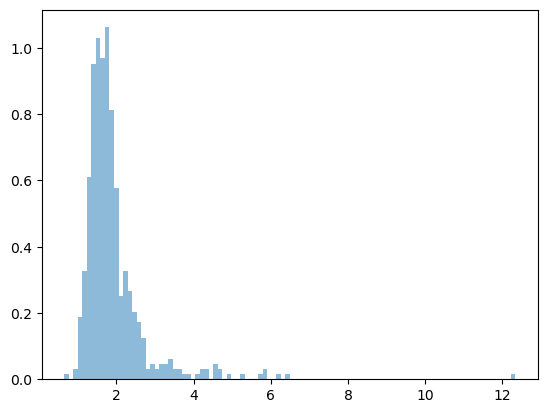

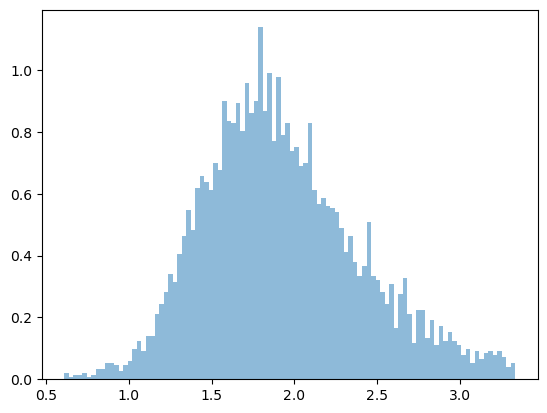

In [312]:
#Make a dictionary of dataframes
dfs = {}
names = []                                              
for path in glob.glob("data/*.csv"):
    if path=="data/UMIK_allSources.csv" or path=="data/df_UMIK_allSources.csv":
        continue
    name = os.path.splitext(os.path.basename(path))[0]  
    names.append(name)
    dfs[name] = pd.read_csv(path)

# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass


clean_ace = dfs['UMIK_Ace'].dropna()


q1, q3 = clean_ace['protein_level'].quantile([0.25, 0.75])
iqr           = q3 - q1
lower_fence   = q1 - 1.5 * iqr
upper_fence   = q3 + 1.5 * iqr

# 4. Keep only non-outliers
clean_no_outliers = clean_ace[(clean_ace['protein_level'] >= lower_fence) & (clean_ace['protein_level'] <= upper_fence)]

# 5. (Optional) assign back to your DataFrame
df_clean_Ace = df.loc[clean_no_outliers.index].copy()
dfs['UMIK_Ace'] = df_clean_Ace
plt.figure()
plt.hist(df_clean_Ace['protein_level'], bins=100, density=True, alpha=0.5, label='Cleaned Protein Levels')
plt.show()

clean_lac = dfs['UMIK_Lac'].dropna()
q1, q3 = clean_lac['protein_level'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr
# Keep only non-outliers
clean_lac_no_outliers = clean_lac[(clean_lac['protein_level'] >= lower_fence) & (clean_lac['protein_level'] <= upper_fence)]
dfs['UMIK_Lac'] = clean_lac_no_outliers

plt.figure()
plt.hist(clean_lac_no_outliers['protein_level'], bins=100, density=True, alpha=0.5, label='Cleaned Lac Protein Levels')
plt.show()

In [314]:
clean_lac_no_outliers

,div_and_fold,fold_growth,division_ratio,added_length,generationtime,length_birth,length_final,growth_rate,lineage_ID,generation,start_time,end_time,protein_level
0,1.151026,0.594680,0.623327,1.879380,1.166667,2.219959,4.099340,0.509726,666.0,0.0,0.000000,1.166667,1.803608
1,1.008117,0.513747,0.563733,1.821682,0.833333,2.310933,4.132615,0.616496,666.0,1.0,1.333333,2.166667,1.551890
2,0.967799,0.564080,0.523503,1.836105,1.000000,2.163436,3.999541,0.564080,666.0,2.0,2.333333,3.333333,1.639515
3,0.978721,0.501920,0.561829,1.667378,0.833333,2.247058,3.914436,0.602304,666.0,3.0,3.500000,4.333333,1.464834
4,0.942026,0.459725,0.554108,1.518480,0.833333,2.169019,3.687499,0.551670,666.0,4.0,4.500000,5.333333,1.265924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6377,1.175477,0.661879,0.568530,2.188298,1.166667,2.049787,4.238085,0.567325,951.0,18.0,25.500000,26.666667,1.923584
6378,0.917593,0.511694,0.537816,1.609531,1.000000,2.279308,3.888839,0.511694,951.0,19.0,26.833333,27.833333,1.522839
6380,1.035178,0.453492,0.629054,2.137110,1.000000,3.310214,5.447323,0.453492,951.0,21.0,30.666667,31.666667,1.899397
6381,0.991503,0.477281,0.584323,2.218043,1.666667,3.182996,5.401039,0.286369,951.0,22.0,31.833333,33.500000,1.946996


1
2
3
4
5
6
7
8
9


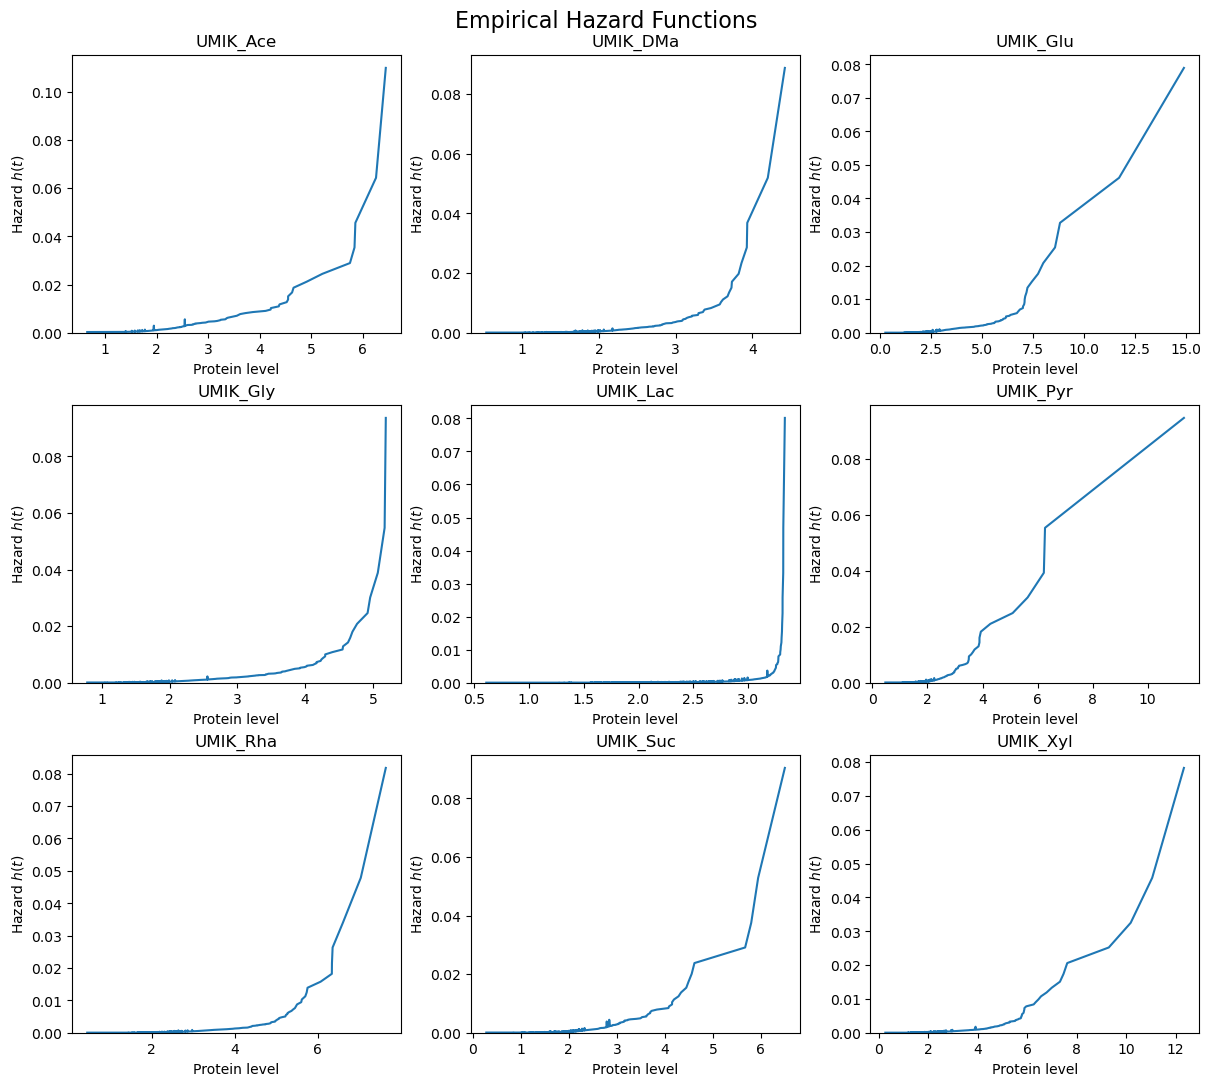

In [318]:
hazards = []
i = 0                         
for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))
    i += 1
    print(i)

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):

    """#remove extreme values
    if name == "UMIK_Ace":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]
    elif name == "UMIK_Pyr":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]"""

    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

In [322]:
def logistic_survival(t, a, b):
    return 1 / (1 + np.exp(a * (t - b)))

def generalized_logistic_survival(t, tau, k, alpha):
    return 1 / (1 + (t / tau)**k)**alpha

def generalized_logistic_hazard(t, tau, k, alpha):
    t = np.asarray(t)
    term = (t / tau)
    numerator = alpha * k / tau * term**(k - 1)
    denominator = 1 + term**k
    return numerator / denominator

# Survival and Hazard funciton as a funcion of protein level

$S(p) = \frac{1}{\left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a}}$

$h(p) = \frac{a k}{\tau^k} \cdot \frac{p^{k-1}}{1 + \left( \frac{p}{\tau} \right)^k}$

$f(p) = \frac{a \cdot k \cdot p^{k-1}}{\tau^k \left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a + 1}}$

$p$: independent variable (protein level)

$\tau$: inflection point (location)

$k$: shape/steepness

$a$: scale or tail weight parameter

# Survival and Hazard funciton as a funcion of time

$p(t) = c m_D \left(e^{\alpha t} - 1\right)$ : Protein growth as a function of time $t$


$S(t) = \frac{1}{\left(1 + \left( \frac{c m_D (e^{\alpha t} - 1)}{\tau} \right)^k \right)^{\alpha}}$

$h(t) = \left[ \frac{\alpha k}{\tau} \cdot \frac{\left( \frac{p(t)}{\tau} \right)^{k-1}}{1 + \left( \frac{p(t)}{\tau} \right)^k} \right] \cdot c m_D \alpha e^{\alpha t}$

UMIK_Ace
UMIK_DMa
UMIK_Glu
UMIK_Gly
UMIK_Lac
UMIK_Pyr
UMIK_Rha
UMIK_Suc
UMIK_Xyl


C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\2431327484.py:5: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (t / tau)**k)**alpha
C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\2431327484.py:5: RuntimeWarning: divide by zero encountered in power
  return 1 / (1 + (t / tau)**k)**alpha


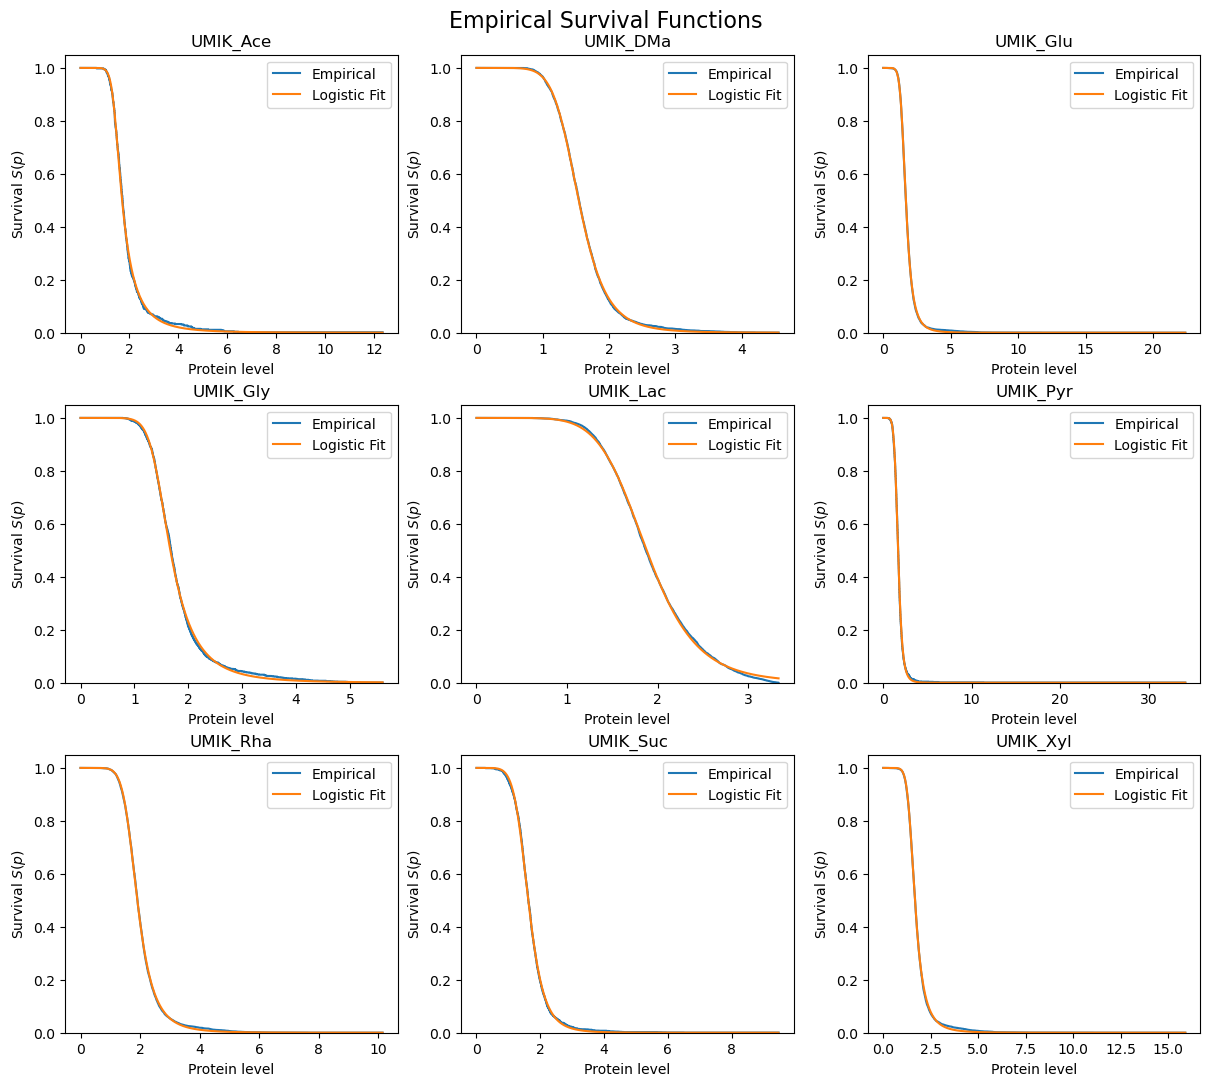

In [326]:
hazards = []                         

for name, df in dfs.items():
    print(name)         
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival, a, f))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               
fittingParams = []

for ax, (name, grid, h, survival, a, f) in zip(axes, hazards):

    popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
    grid_fit = np.linspace(min(grid), max(grid), len(grid))
    survival_fit = generalized_logistic_survival(grid_fit, *popt)
    fittingParams.append(popt)
    
    ax.plot(grid, survival, lw=1.5, label='Empirical')
    ax.plot(grid_fit, survival_fit, label='Logistic Fit')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Survival Functions", fontsize=16, y=1.02)
plt.show()

fittingParams = pd.DataFrame(fittingParams)
fittingParams.columns = ["u", "v", "omega2"]

In [328]:
sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]

fittingParams.index = sugars

fittingParams

,u,v,omega2
Ace,1.435071,10.902389,0.348062
DMa,1.520967,7.687937,0.926973
Glu,1.545852,8.271839,0.644072
Gly,1.486254,9.993666,0.487834
Lac,1.920109,6.635224,1.111569
Pyr,1.695653,6.883056,1.060456
Rha,1.777183,8.197721,0.675184
Suc,1.627657,6.696428,1.008733
Xyl,1.503152,9.208714,0.543765


In [330]:
latex_table = fittingParams.to_latex(index=True, column_format="lccc", float_format="%.4f")
print(latex_table)

\begin{tabular}{lccc}
\toprule
 & u & v & omega2 \\
\midrule
Ace & 1.4351 & 10.9024 & 0.3481 \\
DMa & 1.5210 & 7.6879 & 0.9270 \\
Glu & 1.5459 & 8.2718 & 0.6441 \\
Gly & 1.4863 & 9.9937 & 0.4878 \\
Lac & 1.9201 & 6.6352 & 1.1116 \\
Pyr & 1.6957 & 6.8831 & 1.0605 \\
Rha & 1.7772 & 8.1977 & 0.6752 \\
Suc & 1.6277 & 6.6964 & 1.0087 \\
Xyl & 1.5032 & 9.2087 & 0.5438 \\
\bottomrule
\end{tabular}



In [332]:
# Define the data
data = [
    ["Ace", 1.08, 5.44, 0.78, 0.50, 0.03, 0.17, 0.05],
    ["DMa", 1.07, 2.96, 1.85, 0.52, 0.03, 0.32, 0.08],
    ["Glu", 1.23, 2.79, 1.66, 0.57, 0.04, 0.54, 0.15],
    ["Gly", 1.39, 3.99, 1.37, 0.55, 0.04, 0.35, 0.08],
    ["Lac", 1.74, 1.74, 1.33, 0.60, 0.04, 0.50, 0.13],
    ["Pyr", 1.26, 3.43, 1.50, 0.52, 0.04, 0.37, 0.12],
    ["Rha", 1.57, 5.08, 1.00, 0.54, 0.04, 0.26, 0.06],
    ["Suc", 1.31, 3.32, 1.51, 0.51, 0.04, 0.29, 0.10],
    ["Xyl", 1.28, 3.49, 1.17, 0.57, 0.04, 0.42, 0.09]
]

# Define the column names
columns = ["Sugar", "u", "v", "omega2", "μ_f", "σ_f", "μ_α", "σ_α"]

# Create the DataFrame
mc_params = pd.DataFrame(data, columns=columns)

# Display the DataFrame
mc_params


,Sugar,u,v,omega2,μ_f,σ_f,μ_α,σ_α
0,Ace,1.08,5.44,0.78,0.50,0.03,0.17,0.05
1,DMa,1.07,2.96,1.85,0.52,0.03,0.32,0.08
2,Glu,1.23,2.79,1.66,0.57,0.04,0.54,0.15
3,Gly,1.39,3.99,1.37,0.55,0.04,0.35,0.08
4,Lac,1.74,1.74,1.33,0.60,0.04,0.50,0.13
5,Pyr,1.26,3.43,1.50,0.52,0.04,0.37,0.12
6,Rha,1.57,5.08,1.00,0.54,0.04,0.26,0.06
7,Suc,1.31,3.32,1.51,0.51,0.04,0.29,0.10
8,Xyl,1.28,3.49,1.17,0.57,0.04,0.42,0.09


C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\4150033906.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].text(u[i], v[i], label, fontsize=10, ha='right', va='bottom')
C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\4150033906.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].text(u[i], w[i], label, fontsize=10, ha='right', va='bottom')
C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\4150033906.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

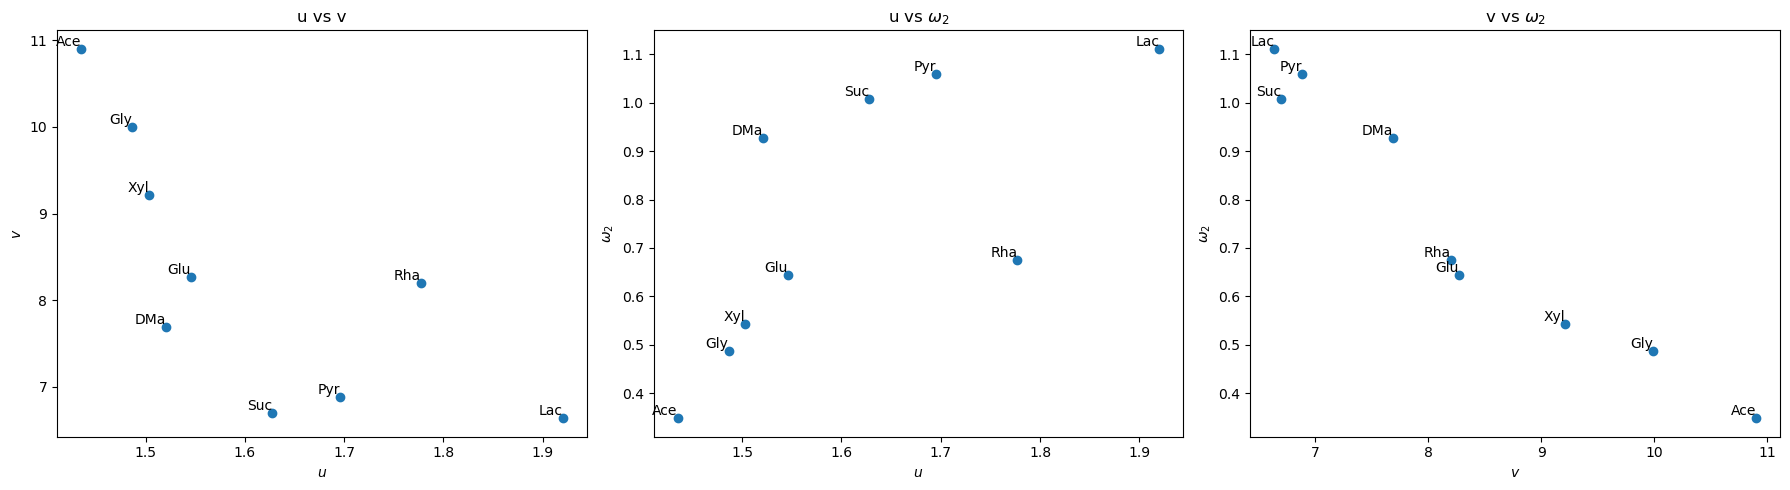

In [334]:
u = fittingParams["u"]
v = fittingParams["v"]
w = fittingParams["omega2"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot 1: u vs v
axes[0].scatter(u, v)
for i, label in enumerate(sugars):
    axes[0].text(u[i], v[i], label, fontsize=10, ha='right', va='bottom')
axes[0].set_xlabel('$u$')
axes[0].set_ylabel('$v$')
axes[0].set_title('u vs v')

# Plot 2: u vs omega2
axes[1].scatter(u, w)
for i, label in enumerate(sugars):
    axes[1].text(u[i], w[i], label, fontsize=10, ha='right', va='bottom')
axes[1].set_xlabel('$u$')
axes[1].set_ylabel(r'$\omega_2$')
axes[1].set_title(r'u vs $\omega_2$')

# Plot 3: v vs omega2
axes[2].scatter(v, w)
for i, label in enumerate(sugars):
    axes[2].text(v[i], w[i], label, fontsize=10, ha='right', va='bottom')
axes[2].set_xlabel('$v$')
axes[2].set_ylabel(r'$\omega_2$')
axes[2].set_title(r'v vs $\omega_2$')

plt.tight_layout()
plt.show()


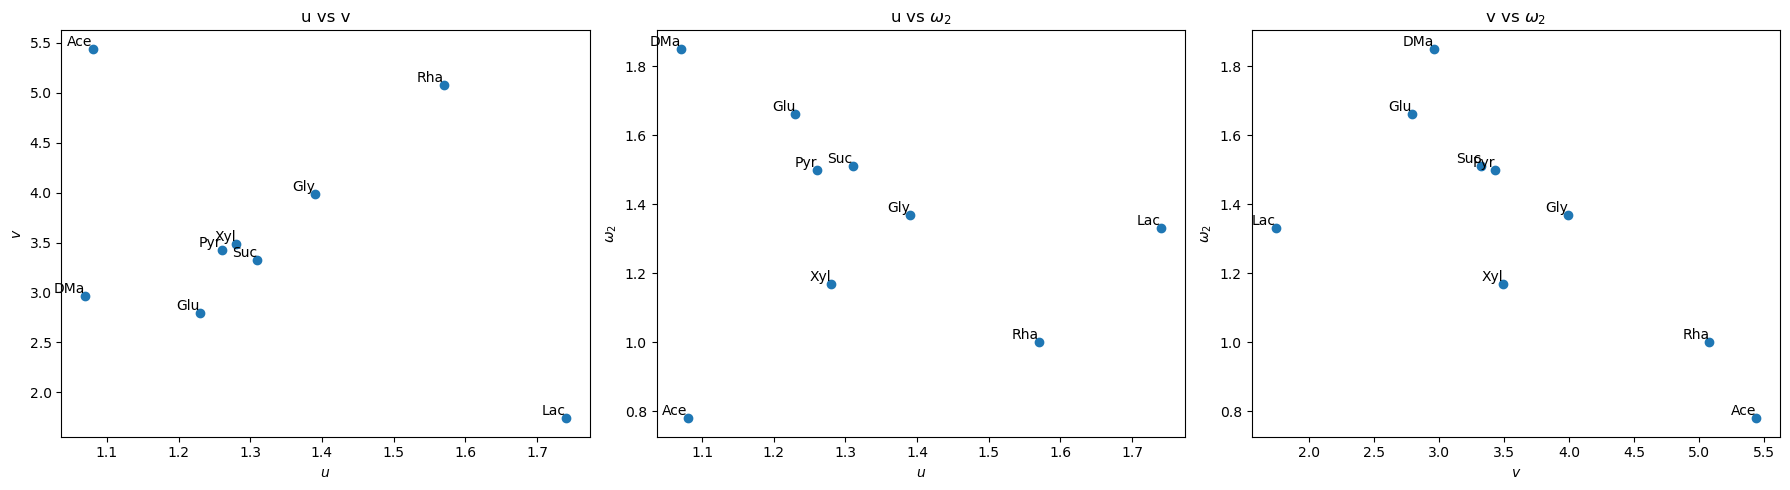

In [335]:
u = mc_params["u"]
v = mc_params["v"]
w = mc_params["omega2"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot 1: u vs v
axes[0].scatter(u, v)
for i, label in enumerate(sugars):
    axes[0].text(u[i], v[i], label, fontsize=10, ha='right', va='bottom')
axes[0].set_xlabel('$u$')
axes[0].set_ylabel('$v$')
axes[0].set_title('u vs v')

# Plot 2: u vs omega2
axes[1].scatter(u, w)
for i, label in enumerate(sugars):
    axes[1].text(u[i], w[i], label, fontsize=10, ha='right', va='bottom')
axes[1].set_xlabel('$u$')
axes[1].set_ylabel(r'$\omega_2$')
axes[1].set_title(r'u vs $\omega_2$')

# Plot 3: v vs omega2
axes[2].scatter(v, w)
for i, label in enumerate(sugars):
    axes[2].text(v[i], w[i], label, fontsize=10, ha='right', va='bottom')
axes[2].set_xlabel('$v$')
axes[2].set_ylabel(r'$\omega_2$')
axes[2].set_title(r'v vs $\omega_2$')

plt.tight_layout()
plt.show()


# Hazard function from survial fit (DMa)

In [392]:
grid = hazards[2][1]
h = hazards[2][2]
survival = hazards[2][3]
a = hazards[2][4]
f = hazards[2][5]

In [394]:
popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
grid_fit = np.linspace(min(grid), max(grid), len(grid))

#popt = np.array([1.07,2.96,1.85])
survival_fit = generalized_logistic_survival(grid_fit, *popt)

popt

C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\2431327484.py:5: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (t / tau)**k)**alpha


array([1.54585207, 8.27183947, 0.64407216])

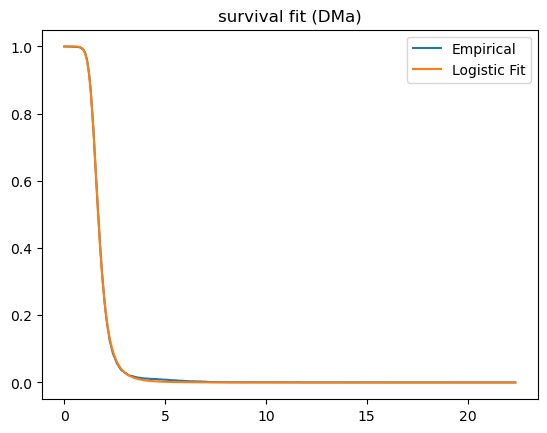

In [396]:
plt.plot(grid, survival, lw=1.5, label='Empirical')
plt.plot(grid_fit, survival_fit, label='Logistic Fit')
plt.title("survival fit (DMa)")
plt.legend()

In [397]:
hazard = np.empty(len(grid)-1, dtype=float)
for p in range(len(grid) - 1):
    if survival_fit[p] > 0 and survival_fit[p+1] > 0:
        hazard[p] = - (np.log(survival_fit[p+1]) - np.log(survival_fit[p])) / (grid_fit[p+1] - grid_fit[p])
    else:
        hazard[p] = 0

Text(0.5, 1.0, 'hazard from survival fit (DMa)')

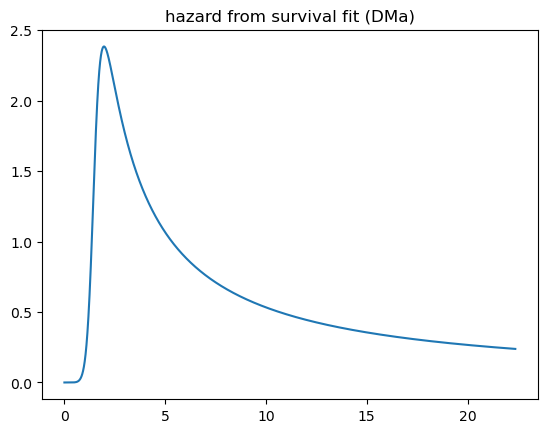

In [400]:
plt.plot(grid_fit[:-1],hazard)
plt.title("hazard from survival fit (DMa)")

In [379]:
def protein_levels_at_division_pdf(p, alpha, k, tau):
    # Compute the probability density function (PDF) of the protein levels
    return (alpha * k/(tau**k)) * (p**(k-1)) / ((1 + (p/tau)**k)**(alpha + 1))


In [381]:
def metropolis_hastings(unnorm_pdf, alpha, k, tau, n_samples=100000, proposal_width=1.0, burn_in=50000):
    samples = []
    p_current = np.random.rand() + 0.1  # initial value > 0
    for _ in range(n_samples + burn_in):
        p_proposal = np.random.normal(p_current, proposal_width)
        if p_proposal <= 0:
            continue  # stay in domain

        # Acceptance probability
        p_accept = min(1, unnorm_pdf(p_proposal, alpha, k, tau) / unnorm_pdf(p_current, alpha, k, tau))

        if np.random.rand() < p_accept:
            p_current = p_proposal

        samples.append(p_current)

    return np.array(samples[burn_in:])



### Sampling with determistic parameters

C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\445823740.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = fittingParams['omega2'][i]
C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\445823740.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  k = fittingParams['v'][i]
C:\Users\yusuf\AppData\Local\Temp\ipykernel_23540\445823740.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tau = fittingParams['u'][i]


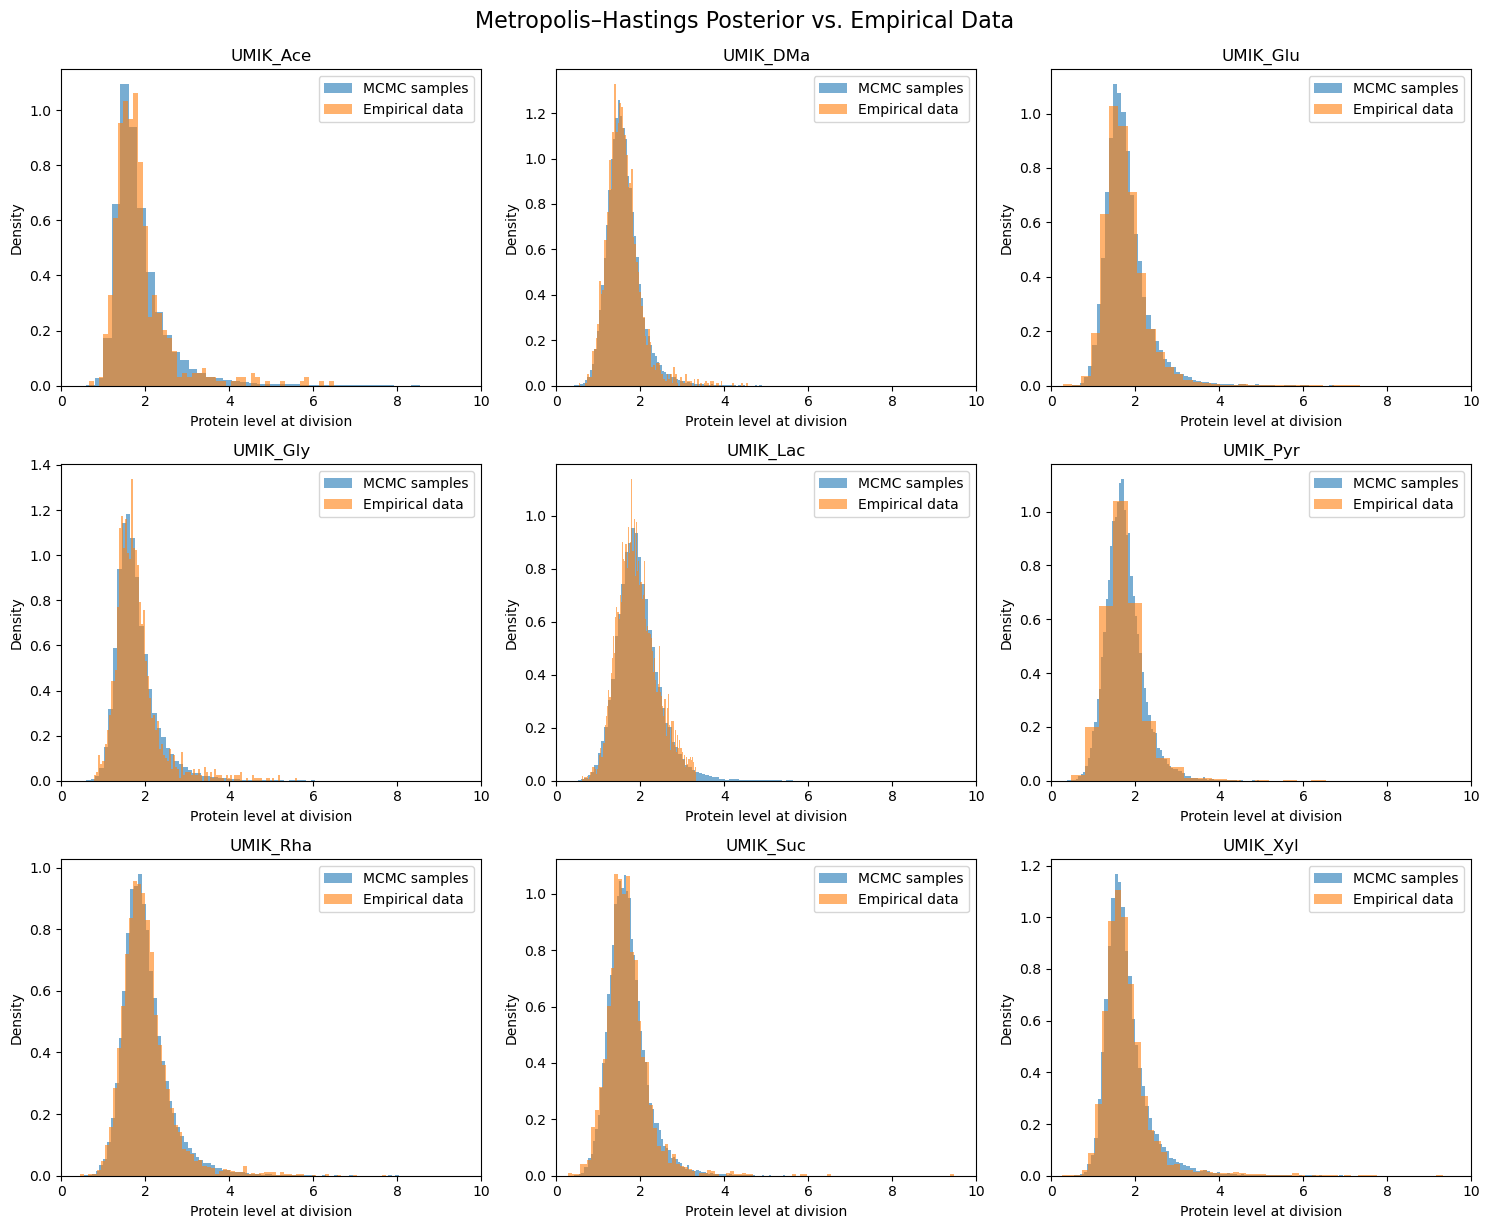

In [384]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # 3x3 grid
axs = axs.flatten()  # flatten so we can index as a list

for i in range(len(fittingParams['u'])):
    alpha = fittingParams['omega2'][i]
    k = fittingParams['v'][i]
    tau = fittingParams['u'][i]

    samples = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau)
    posterior_samples = samples
    empirical_protein_level = dfs[names[i]]["protein_level"].dropna()

    ax = axs[i]
    ax.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
    ax.hist(empirical_protein_level, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')
    ax.set_xlim(0, 10)
    ax.set_title(f"{names[i]}")
    ax.set_xlabel("Protein level at division")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.suptitle("Metropolis–Hastings Posterior vs. Empirical Data", fontsize=16, y=1.02)
plt.show()


In [385]:
empirical_protein_level = dfs["UMIK_Ace"]["protein_level"]
empirical_protein_level = np.sort(empirical_protein_level)
d = np.diff(empirical_protein_level, n=1)
print(np.sort(d[:10]))
print(np.sum(d[~np.isnan(d)]))
empirical_protein_level = dfs["UMIK_Gly"]["protein_level"]
empirical_protein_level = np.sort(empirical_protein_level)
d = np.diff(empirical_protein_level, n=1)
print(np.sort(d[:10]))
print(np.sum(d[~np.isnan(d)]))


[0.00050797 0.00092617 0.0047407  0.00522709 0.01804718 0.02030116
 0.02211813 0.02616048 0.05184684 0.28438523]
11.680967165535991
[0.00178037 0.00260428 0.00268458 0.00915046 0.01064725 0.01480817
 0.01784696 0.02142741 0.021604   0.03424969]
4.816996962509291


In [402]:
grid = hazards[2][1]
h = hazards[2][2]
survival = hazards[2][3]

In [434]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import time

start_time = time.time()

# Survival function S(t; u, v, omega2)
def survival_function(t, u, v, omega2, m_D=1.0, alpha=0.35):
    p = m_D * (np.exp(alpha * t) - 1)
    return (1 + (p / u) ** v) ** (-omega2)

# Log-likelihood comparing model S(t) to empirical S_empirical
def log_likelihood(params, t_data, S_empirical):
    u, v, omega2 = params
    if u <= 0 or v <= 0 or omega2 <= 0:
        return -np.inf  # invalid params
    
    S_model = survival_function(t_data, u, v, omega2)
    
    # avoid log(0)
    S_model = np.clip(S_model, 1e-10, 1)
    S_empirical = np.clip(S_empirical, 1e-10, 1)

    return -np.sum((S_model - S_empirical) ** 2)  # or use: np.sum(np.log(S_model)) if probabilistic

# Uniform prior: bounded support
def prior_valid(params):
    u, v, omega2 = params
    return (0 < u < 20) and (0 < v < 20) and (0 < omega2 < 20)

# Log posterior = log likelihood + log prior
def log_posterior(params, t_data, S_empirical):
    if not prior_valid(params):
        return -np.inf
    return log_likelihood(params, t_data, S_empirical)  # flat prior

# Metropolis-Hastings sampler
def metropolis_hastings(log_post_fn, initial_params, n_steps, proposal_scale, t_data, S_empirical):
    samples = []
    current_params = np.array(initial_params)
    current_log_post = log_post_fn(current_params, t_data, S_empirical)

    for step in range(n_steps):
        proposal = current_params + np.random.normal(0, proposal_scale, size=3)
        proposed_log_post = log_post_fn(proposal, t_data, S_empirical)

        accept = np.random.rand() < np.exp(proposed_log_post - current_log_post)

        if accept:
            current_params = proposal
            current_log_post = proposed_log_post
        
        samples.append(current_params)

    return np.array(samples)

sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]
#sugars = ["DMa","Lac"]
for i in range(len(sugars)):
    t_data = hazards[i][1]
    S_empirical = hazards[i][3]
    
    # Run sampler
    initial_params = [1.0, 5.0, 1.0]         # initial guess for [u, v, omega2]
    n_steps = 20000                      # number of MCMC steps
    proposal_scale = [0.05, 0.1, 0.05]      # stddev for proposals
    
    samples = metropolis_hastings(
        log_posterior,
        initial_params,
        n_steps,
        proposal_scale,
        t_data,
        S_empirical
    )
    
    print(sugars[i])
    np.savetxt(f'sample_{sugars[i]}.txt', samples)



print("Elapsed time: {:.2f} seconds".format(time.time() - start_time))


DMa
Lac
Elapsed time: 77.70 seconds


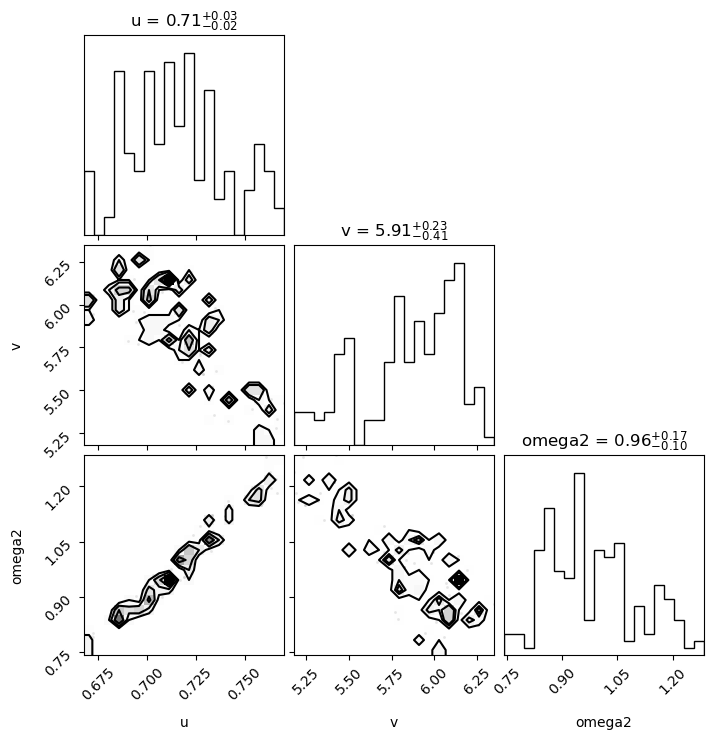

u: 0.7160 ± 0.0240
v: 5.8551 ± 0.2806
omega2: 0.9848 ± 0.1208


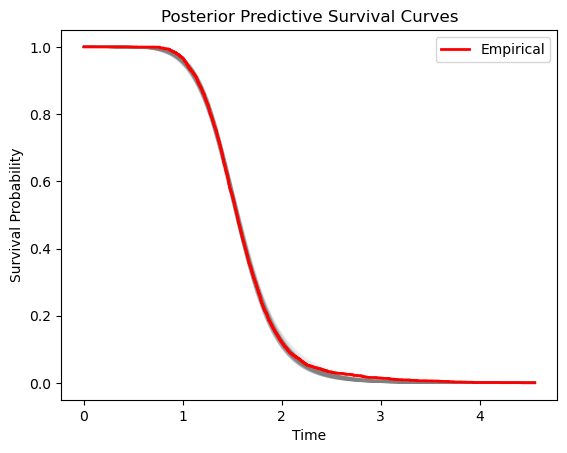

In [436]:
# Burn-in and thinning
burn = int(0.1 * len(samples))
samples_thinned = samples[burn::10]

# Plot corner
param_names = ["u", "v", "omega2"]
corner.corner(samples_thinned, labels=param_names, show_titles=True)
plt.show()

# Posterior summary
means = np.mean(samples_thinned, axis=0)
stds = np.std(samples_thinned, axis=0)
for name, mean, std in zip(param_names, means, stds):
    print(f"{name}: {mean:.4f} ± {std:.4f}")

# Optional: Posterior predictive survival curves
t_vals = np.linspace(0, max(t_data), 200)
m_D = 1.0
alpha = 0.35

plt.figure()
for s in samples_thinned[np.random.choice(len(samples_thinned), 100, replace=False)]:
    u, v, omega2 = s
    S = survival_function(t_vals, u, v, omega2, m_D, alpha)
    plt.plot(t_vals, S, alpha=0.1, color='gray')

# Plot empirical survival
plt.plot(t_data, S_empirical, 'r-', lw=2, label="Empirical")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Posterior Predictive Survival Curves")
plt.legend()
plt.show()

In [448]:
array = np.loadtxt('sample_DMa.txt')


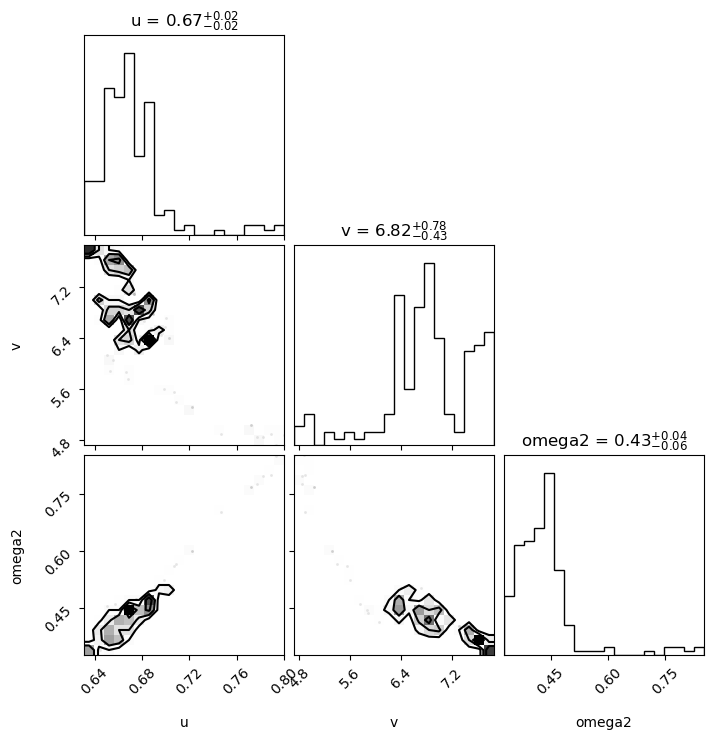

In [450]:
burn = int(0.1 * len(samples))
samples_thinned = array[burn::10]

param_names = ["u", "v", "omega2"]
corner.corner(samples_thinned, labels=param_names, show_titles=True)
plt.show()
